# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [ ]:


import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub(r"[\n\t\s]", " ", data)
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    index = 0
    for char in data:
      if char not in voc2ind:
        voc2ind[char] = index
        index += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    data_text = []
    for char in data:
      data_text.append(voc2ind[char])

    length = (int) (len(data_text) * 0.8)
    train_text = data_text[0:length]
    test_text = data_text[length:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))

prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        self.dataset = None
        self.tokens = None
        self.dataset_sorted = None
        self.len_subdivision = 0
        self.num_unique_seq = 0 

        with open(data_file, 'rb') as data_pkl:
            self.dataset = pickle.load(data_pkl)

        self.tokens = self.dataset['tokens']
        print("length of tokens:", len(self.tokens))
        # TODO: Any preprocessing on the data to get it to the right shape.
        if len(self.tokens) % self.batch_size != 0:
          new_len = (int) (self.batch_size * (len(self.tokens) / self.batch_size))
          self.tokens = self.tokens[0:new_len]

        self.len_subdivision = (int) (len(self.tokens) / self.batch_size)
        self.num_unique_seq = self.batch_size * math.ceil((float) (self.len_subdivision-1) / self.sequence_length)

        self.dataset_sorted = []
        for i in range(0, (int) (self.num_unique_seq / self.batch_size)):  # 1-3
          for batch in range(self.batch_size): # 0-1
            array = []
            for seq in range(self.sequence_length + 1): # 0-4
              index = batch * self.len_subdivision + i * self.sequence_length + seq
              if index < (batch + 1) * self.len_subdivision:
                array.append(self.tokens[index])
            self.dataset_sorted.append(array)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return self.num_unique_seq

    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        data = self.dataset_sorted[idx]
        return torch.LongTensor(data[:-1]), torch.LongTensor(data[1:])

    def vocab_size(self):
        return len(self.vocab)

In [ ]:
data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 4, 2)

print(data_train.__len__())
print(data_train.__getitem__(0))
print(data_train.__getitem__(1))
print(data_train.__getitem__(2))
print(data_train.__getitem__(3))
print(data_train.__getitem__(4))
print(data_train.__getitem__(5))
print(data_train.__getitem__(6))
print(data_train.__getitem__(7))

length of tokens: 5000121
1250030
(tensor([0, 1, 2, 2]), tensor([1, 2, 2, 3]))
(tensor([13, 14, 15,  4]), tensor([14, 15,  4, 15]))
(tensor([3, 4, 5, 6]), tensor([4, 5, 6, 7]))
(tensor([15, 11,  1, 10]), tensor([11,  1, 10,  6]))
(tensor([7, 7, 8, 2]), tensor([7, 8, 2, 4]))
(tensor([ 6, 40,  3, 34]), tensor([40,  3, 34,  4]))
(tensor([ 4,  1,  9, 10]), tensor([ 1,  9, 10,  4]))
(tensor([ 4, 15,  7, 32]), tensor([15,  7, 32, 37]))


# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)

        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)

        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        # we're pretty sure this is sus
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
  
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 0.1
BEAM_WIDTH = 10

import copy

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
      max_val = torch.argmax(output)
      outputs.append(max_val)
      output, hidden = model.inference(max_val, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
      max_val = np.random.choice(output.shape[1], 1, p=output.flatten().cpu().numpy())
      outputs.append(max_val[0])
      output, hidden = model.inference(torch.tensor(max_val[0]).to(device), hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]
    for ii in range(sequence_length):
      new_beams = []
      for beam in beams:
        # first time
        if len(beam[0]) == 0:
          max_val = np.random.choice(output.shape[1], 1, p=output.flatten().cpu().numpy())
          output, hidden = model.inference(torch.tensor(max_val[0]).to(device), hidden)
        # every other time
        else:
          output, hidden = model.inference(torch.tensor(beam[0][-1]).to(device), beam[2])
        for n in range(beam_width):
          new_beam = list(copy.deepcopy(beam)) # maybe check l8r
          max_val = np.random.choice(output.shape[1], 1, p=output.flatten().cpu().numpy())
          new_beam[0].append(max_val[0])
          new_beam[1] = output
          new_beam[2] = hidden
          new_beam[3] = np.log(output.flatten().cpu().numpy()[max_val[0]])
          new_beams.append(tuple(new_beam))
      sorted(new_beams, key=lambda x: x[3])
      beams = new_beams[:beam_width]

    outputs = beams[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("\nperplexity: ", np.exp(np.mean(losses)))
    perplexity = np.exp(np.mean(losses))
    return np.mean(losses), perplexity


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)
    perplexity = np.exp(np.mean(test_loss))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy, perplexity

length of tokens: 5000121
length of tokens: 1250031
Using device cuda
num workers: 2
checking data_train: 50176
checking data_test: 12544
checking train_loader: 196
checking test_loader: 49
after model
before train
before test
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	^)){^S0t^XJJY^0^^^J0^SS00s`3t hy0SyISw)_JJ^)Y^^0X^^I0{99y^eP^y^^33jj^^^jX^kSS^e^-yIJ^^JJsS&^^0^^^^^J


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	SS&^000^0y^^}-IyXy33^)^^s)J yyyI^e--3JPP)PkPS{PMskMyXXPk&^^0^^^Sy00sSSSk^^0^ykI0y}-e^^^SJXyy-)Jy^0^^


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 4.4905, Accuracy: 7090/1254400 (1%)



  1%|          | 1/196 [00:00<00:35,  5.47it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 4.490549


  7%|▋         | 13/196 [00:01<00:17, 10.19it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 2.704665


 12%|█▏        | 23/196 [00:02<00:15, 11.15it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 2.365529


 17%|█▋        | 33/196 [00:02<00:14, 11.35it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 2.171095


 22%|██▏       | 43/196 [00:03<00:13, 11.55it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 2.037168


 27%|██▋       | 53/196 [00:04<00:12, 11.65it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 1.950859


 32%|███▏      | 63/196 [00:05<00:11, 11.52it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 1.896191


 37%|███▋      | 73/196 [00:06<00:10, 11.51it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 1.838316


 42%|████▏     | 83/196 [00:07<00:09, 11.48it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 1.762518


 47%|████▋     | 93/196 [00:08<00:08, 11.52it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 1.729658


 53%|█████▎    | 103/196 [00:09<00:08, 11.31it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 1.699653


 58%|█████▊    | 113/196 [00:09<00:07, 11.41it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 1.719784


 63%|██████▎   | 123/196 [00:10<00:06, 11.49it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 1.645976


 68%|██████▊   | 133/196 [00:11<00:05, 11.39it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 1.615190


 73%|███████▎  | 143/196 [00:12<00:04, 11.31it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 1.610687


 78%|███████▊  | 153/196 [00:13<00:03, 11.23it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 1.596577


 83%|████████▎ | 163/196 [00:14<00:02, 11.20it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 1.596588


 88%|████████▊ | 173/196 [00:15<00:02, 11.36it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 1.562557


 93%|█████████▎| 183/196 [00:16<00:01, 11.25it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 1.559550


 98%|█████████▊| 193/196 [00:17<00:00, 11.32it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 1.592345


100%|██████████| 196/196 [00:17<00:00, 11.34it/s]


perplexity:  6.9133351198336035


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney was aitt th het tascri aucause teldemort wad tuacced tn wamt . ae dootg tim elf tuer th she dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet hed tam fnm  "  wealated tim  hocling aeck ardstnto the salcrntath h steant  te saraneled to h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	khe and tem fiet aitt the sround tn the  wikt d tim and sefan to honti aam  haiwly and surp i  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ingle walking up into his what I distrden and doing Snape. "Go ancuidite Ministuniccy Madmagan't seemed to housed. "Verent were't like dismineding; he cannus Mab fight it...."Cmunger Volday?" "I don'.



  2%|▏         | 3/196 [00:00<00:38,  5.06it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.562594


  7%|▋         | 13/196 [00:01<00:19,  9.35it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 1.511065


 12%|█▏        | 23/196 [00:02<00:15, 10.86it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 1.556599


 17%|█▋        | 33/196 [00:03<00:14, 11.10it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 1.540139


 22%|██▏       | 43/196 [00:03<00:13, 11.21it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 1.519257


 27%|██▋       | 53/196 [00:04<00:12, 11.18it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 1.509253


 32%|███▏      | 63/196 [00:05<00:11, 11.10it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.516245


 37%|███▋      | 73/196 [00:06<00:10, 11.22it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.511936


 42%|████▏     | 83/196 [00:07<00:10, 11.09it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.477010


 47%|████▋     | 93/196 [00:08<00:09, 11.10it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.495270


 53%|█████▎    | 103/196 [00:09<00:08, 11.18it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.565437


 58%|█████▊    | 113/196 [00:10<00:07, 11.23it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 1.507427


 63%|██████▎   | 123/196 [00:11<00:06, 11.04it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 1.481352


 68%|██████▊   | 133/196 [00:12<00:05, 11.02it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 1.453499


 73%|███████▎  | 143/196 [00:12<00:04, 11.11it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.465197


 78%|███████▊  | 153/196 [00:13<00:03, 11.01it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.501376


 83%|████████▎ | 163/196 [00:14<00:02, 11.01it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.522334


 88%|████████▊ | 173/196 [00:15<00:02, 11.06it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.470279


 93%|█████████▎| 183/196 [00:16<00:01, 10.92it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.471609


 98%|█████████▊| 193/196 [00:17<00:00, 10.98it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.473748


100%|██████████| 196/196 [00:17<00:00, 11.02it/s]


perplexity:  4.468443960450427


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ths titt th hit thtcr  autause holdemort wad tlacted tn womt . aa diitg tim elf tner th hhe mnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what hed tam hlm  "t wealase  tim  hocling tack ard tnto the saler thth h lteant  he haraneled th h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	th  hnd tes hiel sitt the sround tn the  woke d tim and hefan th horri aim  hhiwly atd ttrp y  huck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ou here, don't cliquity." Gefore had not can't be sling into Ron all this Hould of disappoaratite the of carrived" his had him doessing. He knok him foor "There's about in the tell of I magice forward



  1%|          | 2/196 [00:00<00:38,  4.99it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.471086


  7%|▋         | 13/196 [00:01<00:18,  9.64it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.454177


 12%|█▏        | 23/196 [00:02<00:15, 10.89it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.486653


 17%|█▋        | 33/196 [00:03<00:14, 11.09it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.473083


 22%|██▏       | 43/196 [00:04<00:13, 11.11it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.503416


 27%|██▋       | 53/196 [00:04<00:12, 11.19it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.455450


 32%|███▏      | 63/196 [00:05<00:11, 11.23it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.454233


 37%|███▋      | 73/196 [00:06<00:11, 11.03it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.467338


 42%|████▏     | 83/196 [00:07<00:10, 11.01it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.451749


 47%|████▋     | 93/196 [00:08<00:09, 11.14it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.460928


 53%|█████▎    | 103/196 [00:09<00:08, 11.04it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.471288


 58%|█████▊    | 113/196 [00:10<00:07, 11.11it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.473207


 63%|██████▎   | 123/196 [00:11<00:06, 11.01it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.449855


 68%|██████▊   | 133/196 [00:12<00:05, 11.00it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.426882


 73%|███████▎  | 143/196 [00:13<00:04, 11.02it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.456023


 78%|███████▊  | 153/196 [00:13<00:03, 10.96it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.464797


 83%|████████▎ | 163/196 [00:14<00:02, 11.02it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.479797


 88%|████████▊ | 173/196 [00:15<00:02, 10.93it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.444572


 93%|█████████▎| 183/196 [00:16<00:01, 10.99it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.470156


 98%|█████████▊| 193/196 [00:17<00:00, 10.96it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.501348


100%|██████████| 196/196 [00:17<00:00, 10.94it/s]


perplexity:  4.322060375711527


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney ohs aitt hh hot hhter  aufause holdemort wad nuacted tn womt . aa wiitg tim elf oner th hhe snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what hed sas srm  "t wemecsed tim  hriling aack ard anto the saler ohth h pueatt  he saraneled oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	th  and ses maet sitt hhe sround st the  witeed him and sugan to hotei ais  hhiwly atd surp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. This SnIThart --" Stapport, Itsenve!" Harry could him as he ased Ron the oten whimself casing his upon but the kilgorvifor while his bed. Snape. All whole had culping his ribe watcut Harry Frunt quiet



  1%|          | 2/196 [00:00<00:39,  4.92it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.469541


  6%|▌         | 12/196 [00:01<00:20,  9.14it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.431023


 11%|█         | 22/196 [00:02<00:16, 10.72it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.473616


 16%|█▋        | 32/196 [00:03<00:14, 10.97it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.455475


 21%|██▏       | 42/196 [00:03<00:14, 10.99it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.453542


 27%|██▋       | 52/196 [00:04<00:13, 10.88it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.444871


 32%|███▏      | 62/196 [00:05<00:12, 10.78it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.456458


 37%|███▋      | 72/196 [00:06<00:11, 10.87it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.452838


 42%|████▏     | 82/196 [00:07<00:10, 10.97it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.445795


 47%|████▋     | 92/196 [00:08<00:09, 10.76it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.440677


 52%|█████▏    | 102/196 [00:09<00:08, 10.84it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.469701


 57%|█████▋    | 112/196 [00:10<00:07, 10.90it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.449315


 62%|██████▏   | 122/196 [00:11<00:06, 10.93it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.433706


 67%|██████▋   | 132/196 [00:12<00:05, 10.94it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.425738


 72%|███████▏  | 142/196 [00:13<00:04, 10.93it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.483937


 78%|███████▊  | 152/196 [00:14<00:04, 10.80it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.440490


 83%|████████▎ | 162/196 [00:15<00:03, 10.89it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.449835


 88%|████████▊ | 172/196 [00:15<00:02, 10.91it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.429876


 93%|█████████▎| 182/196 [00:16<00:01, 10.74it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.451132


 98%|█████████▊| 192/196 [00:17<00:00, 10.78it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.470385


100%|██████████| 196/196 [00:18<00:00, 10.81it/s]


perplexity:  4.249712979040218


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y ohs titt th hot thlcr  aufause holdemort wad nuacted tn womt . ae diang tim elf ofer th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 mhat hed bes mlm  "t weaiased tim  aoiling alck ard tnto the saler ahth h ltiats  oe saranbled oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes miet aift the slound on the  witeed tim and segan to holry aim  ahiwly atd strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "It's a Nicking Snaper, myatter on I bed paxe on the 4or both? Flupt who'lly you morning face of back   "-- the four year new Hagrid. Unable twins slip me back and ours wate their els. You can was sta



  1%|          | 2/196 [00:00<00:39,  4.93it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.444045


  6%|▌         | 12/196 [00:01<00:20,  9.13it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.502796


 11%|█         | 22/196 [00:02<00:16, 10.58it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.501059


 16%|█▋        | 32/196 [00:03<00:15, 10.76it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.444460


 21%|██▏       | 42/196 [00:04<00:14, 10.93it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.429699


 27%|██▋       | 52/196 [00:04<00:13, 10.85it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.424279


 32%|███▏      | 62/196 [00:05<00:12, 10.85it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.438614


 37%|███▋      | 72/196 [00:06<00:11, 10.75it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.445931


 42%|████▏     | 82/196 [00:07<00:10, 10.67it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.420242


 47%|████▋     | 92/196 [00:08<00:09, 10.85it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.421047


 52%|█████▏    | 102/196 [00:09<00:08, 10.90it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.452267


 57%|█████▋    | 112/196 [00:10<00:07, 10.76it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.450310


 62%|██████▏   | 122/196 [00:11<00:06, 10.82it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.445761


 67%|██████▋   | 132/196 [00:12<00:05, 10.74it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.412726


 72%|███████▏  | 142/196 [00:13<00:05, 10.70it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.425205


 78%|███████▊  | 152/196 [00:14<00:04, 10.75it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.471071


 83%|████████▎ | 162/196 [00:15<00:03, 10.84it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.457297


 88%|████████▊ | 172/196 [00:16<00:02, 10.81it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.439732


 93%|█████████▎| 182/196 [00:16<00:01, 10.71it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.443716


 98%|█████████▊| 192/196 [00:17<00:00, 10.84it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.445387


100%|██████████| 196/196 [00:18<00:00, 10.72it/s]


perplexity:  4.222235987204229


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas tott th tot thler  tufause holdemort wad nuacted tn womm.. ae doang tim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 soat hed ses srm     weaeased tim  toiling aeck ard tnto the saler ohth h ltiatt  oe sarambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes slet soft the soound on the  wokeed tim and sefan to souei tim  thiwly atd stde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ood on these mad xood gotant down what don't you kust me this, you've got us." Harry's hard as knocolaced througz when this cass. Lording bous if you've got not off worrings fool," Harry and Fudwing f



  2%|▏         | 3/196 [00:00<00:37,  5.17it/s]

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.427811


  7%|▋         | 13/196 [00:01<00:19,  9.20it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.408033


 12%|█▏        | 23/196 [00:02<00:16, 10.49it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.458720


 17%|█▋        | 33/196 [00:03<00:15, 10.85it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.435655


 22%|██▏       | 43/196 [00:04<00:14, 10.89it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.418752


 27%|██▋       | 53/196 [00:05<00:13, 10.85it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.410517


 32%|███▏      | 63/196 [00:05<00:12, 10.78it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.541001


 37%|███▋      | 73/196 [00:06<00:11, 10.80it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.499835


 42%|████▏     | 83/196 [00:07<00:10, 10.72it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.429057


 47%|████▋     | 93/196 [00:08<00:09, 10.67it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.419144


 53%|█████▎    | 103/196 [00:09<00:08, 10.82it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.415550


 58%|█████▊    | 113/196 [00:10<00:07, 10.66it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.433835


 63%|██████▎   | 123/196 [00:11<00:06, 10.64it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.429636


 68%|██████▊   | 133/196 [00:12<00:05, 10.62it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.404871


 73%|███████▎  | 143/196 [00:13<00:04, 10.68it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.418133


 78%|███████▊  | 153/196 [00:14<00:04, 10.64it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.428783


 83%|████████▎ | 163/196 [00:15<00:03, 10.65it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.437732


 88%|████████▊ | 173/196 [00:16<00:02, 10.64it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.414513


 93%|█████████▎| 183/196 [00:17<00:01, 10.71it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.437282


 98%|█████████▊| 193/196 [00:18<00:00, 10.72it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.435775


100%|██████████| 196/196 [00:18<00:00, 10.68it/s]


perplexity:  4.185880341261787


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey whs titt th sot thser  tufause holdemort wad suacted tn womt.. ae wiatg tim elf tuer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 soat hed sem srm   t weaeased tim  hoiling arck ard tnto the saler ohth h btratt  oe sarambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and ses siet soft the sround sn the  wokeed tim and selan to soueiiaim  hhiwly atd stde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "And she?" he sabd forgotten at the varning crows. "You several all's what you see I'm softess; Somerbeled callfing sound. There yes. I think you must moved take you .. colled it merveled me. you read



  1%|          | 2/196 [00:00<00:38,  5.08it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.418885


  6%|▌         | 12/196 [00:01<00:20,  9.02it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.406186


 11%|█         | 22/196 [00:02<00:16, 10.48it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.459651


 16%|█▋        | 32/196 [00:03<00:15, 10.72it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.422063


 21%|██▏       | 42/196 [00:04<00:14, 10.80it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.409834


 27%|██▋       | 52/196 [00:04<00:13, 10.79it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.408112


 32%|███▏      | 62/196 [00:05<00:12, 10.74it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.438713


 37%|███▋      | 72/196 [00:06<00:11, 10.74it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.421798


 42%|████▏     | 82/196 [00:07<00:10, 10.67it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.417110


 47%|████▋     | 92/196 [00:08<00:09, 10.73it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.431211


 52%|█████▏    | 102/196 [00:09<00:08, 10.68it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.421696


 57%|█████▋    | 112/196 [00:10<00:07, 10.61it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.423021


 62%|██████▏   | 122/196 [00:11<00:06, 10.73it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.412021


 67%|██████▋   | 132/196 [00:12<00:05, 10.78it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.395317


 72%|███████▏  | 142/196 [00:13<00:05, 10.70it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.407821


 78%|███████▊  | 152/196 [00:14<00:04, 10.63it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.405855


 83%|████████▎ | 162/196 [00:15<00:03, 10.68it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.418985


 88%|████████▊ | 172/196 [00:16<00:02, 10.59it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.399814


 93%|█████████▎| 182/196 [00:17<00:01, 10.68it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.437888


 98%|█████████▊| 192/196 [00:18<00:00, 10.65it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.464424


100%|██████████| 196/196 [00:18<00:00, 10.62it/s]


perplexity:  4.127401494157091


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey oas iitt th sot thler  tucause yoldemort wad suacted tn iomt.. aarsiang tim elf oner th she snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 mhat sed sem mlm  "t weaeated tim  hoiling alck ard tnto the saler ohth h stratt  oe sarambeed oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  wnd iem miet sitt the soound tn the  wikeed tim ind sefan to soreiiiim  hhiwly ttd stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "  "What you reacher that's before Snapelle she, six you won't!" said Hagrid. "Harry much from Krustachols."  "Welified, he's canstinessor?" said Harry out on the swileroard. "It's offention out of th



  1%|          | 2/196 [00:00<00:37,  5.11it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.444025


  6%|▌         | 12/196 [00:01<00:20,  8.99it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.399645


 11%|█         | 22/196 [00:02<00:16, 10.39it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.463417


 16%|█▋        | 32/196 [00:03<00:15, 10.69it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.433945


 21%|██▏       | 42/196 [00:04<00:14, 10.70it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.402092


 27%|██▋       | 52/196 [00:05<00:13, 10.74it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.395275


 32%|███▏      | 62/196 [00:05<00:12, 10.70it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.411276


 37%|███▋      | 72/196 [00:06<00:11, 10.61it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.432678


 42%|████▏     | 82/196 [00:07<00:10, 10.65it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.400907


 47%|████▋     | 92/196 [00:08<00:09, 10.66it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.390483


 52%|█████▏    | 102/196 [00:09<00:08, 10.69it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.410492


 57%|█████▋    | 112/196 [00:10<00:07, 10.70it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.414519


 62%|██████▏   | 122/196 [00:11<00:06, 10.60it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.428578


 67%|██████▋   | 132/196 [00:12<00:06, 10.64it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.386277


 72%|███████▏  | 142/196 [00:13<00:05, 10.57it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.436769


 78%|███████▊  | 152/196 [00:14<00:04, 10.64it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.400788


 83%|████████▎ | 162/196 [00:15<00:03, 10.62it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.415163


 88%|████████▊ | 172/196 [00:16<00:02, 10.65it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.397210


 93%|█████████▎| 182/196 [00:17<00:01, 10.64it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.414036


 98%|█████████▊| 192/196 [00:18<00:00, 10.59it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.425518


100%|██████████| 196/196 [00:18<00:00, 10.57it/s]


perplexity:  4.096891444099915


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey shs toat th tot thler  aucause toldemort sad suacted tn womt . ae soang tem elf tner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 shat sed ses srm  "  weaeased tim  aoiling alck ard tnto the saler ahth h stratt  se sarambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and ses saet soat the sround sn the  sokeed tim and sefan to sorei aim  ahiwly atd stde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e was dinneling as Dudley beside 1grinnised now Concentrates, cludging to his Hagrif. "Shadowy, did indeeds more times his mottever read. "You screed, What a pomeme sideal door of herver metail, "Harr



  1%|          | 2/196 [00:00<00:40,  4.85it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.416737


  6%|▌         | 12/196 [00:01<00:20,  8.88it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.392871


 11%|█         | 22/196 [00:02<00:16, 10.30it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.440098


 16%|█▋        | 32/196 [00:03<00:15, 10.70it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.425894


 21%|██▏       | 42/196 [00:04<00:14, 10.62it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.403156


 27%|██▋       | 52/196 [00:05<00:13, 10.67it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.406050


 32%|███▏      | 62/196 [00:05<00:12, 10.66it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.399713


 37%|███▋      | 72/196 [00:06<00:11, 10.62it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.404567


 42%|████▏     | 82/196 [00:07<00:10, 10.62it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.386733


 47%|████▋     | 92/196 [00:08<00:09, 10.63it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.407789


 52%|█████▏    | 102/196 [00:09<00:08, 10.65it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.474358


 57%|█████▋    | 112/196 [00:10<00:07, 10.67it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.421269


 62%|██████▏   | 122/196 [00:11<00:07, 10.56it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.396441


 67%|██████▋   | 132/196 [00:12<00:05, 10.67it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.377027


 72%|███████▏  | 142/196 [00:13<00:05, 10.55it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.409522


 78%|███████▊  | 152/196 [00:14<00:04, 10.53it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.389159


 83%|████████▎ | 162/196 [00:15<00:03, 10.60it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.417753


 88%|████████▊ | 172/196 [00:16<00:02, 10.62it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.383717


 93%|█████████▎| 182/196 [00:17<00:01, 10.60it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.415933


 98%|█████████▊| 192/196 [00:18<00:00, 10.60it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.415884


100%|██████████| 196/196 [00:18<00:00, 10.53it/s]


perplexity:  4.073101363329757


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey ohl toat th tot thler  aucause yoldemort wad nuacted tn iomt . te woang tim elf ouer th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Mhet hed bes slm   t weaiated tim  aoiling alck ard tnto the caler ahth h ctlitt  oe sarambled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes mlet aoat the clound on the  wokeed tim and selan to solei aim  ahiwly atd shre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. oting blush in the floor of her onk   a bir office, allays and raised. "Groffind Olftic was sometting me-time Mernice was a gold my face Ron and Ron." whispered nor exain howletch hit Harry and Black 



  1%|          | 2/196 [00:00<00:38,  5.08it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.408946


  6%|▌         | 12/196 [00:01<00:20,  9.14it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.386157


 11%|█         | 22/196 [00:02<00:16, 10.47it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.423954


 16%|█▋        | 32/196 [00:03<00:15, 10.67it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.411168


 21%|██▏       | 42/196 [00:04<00:14, 10.69it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.406347


 27%|██▋       | 52/196 [00:04<00:13, 10.70it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.405359


 32%|███▏      | 62/196 [00:05<00:12, 10.71it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.408768


 37%|███▋      | 72/196 [00:06<00:11, 10.63it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.414738


 42%|████▏     | 82/196 [00:07<00:10, 10.67it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.386212


 47%|████▋     | 92/196 [00:08<00:09, 10.64it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.387913


 52%|█████▏    | 102/196 [00:09<00:08, 10.64it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.410535


 57%|█████▋    | 112/196 [00:10<00:07, 10.60it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.400190


 62%|██████▏   | 122/196 [00:11<00:06, 10.63it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.392886


 67%|██████▋   | 132/196 [00:12<00:06, 10.53it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.373500


 72%|███████▏  | 142/196 [00:13<00:05, 10.60it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.402192


 78%|███████▊  | 152/196 [00:14<00:04, 10.63it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.412989


 83%|████████▎ | 162/196 [00:15<00:03, 10.60it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.416867


 88%|████████▊ | 172/196 [00:16<00:02, 10.60it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.385963


 93%|█████████▎| 182/196 [00:17<00:01, 10.61it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.415939


 98%|█████████▊| 192/196 [00:18<00:00, 10.50it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.422915


100%|██████████| 196/196 [00:18<00:00, 10.58it/s]


perplexity:  4.0534295723919005


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey ohn tiat th tot thlcr  aucause holdemort wad buanted tn womt.. aa woang oim elf ouer th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Mhat hed bas elm  "t weaiase  tim  aoiling aack ard anto the caler ahth h ctiint  oa harambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and hes eiet aott the cround an the  wokeed tim and sufan to holei aim  ahiwly and shre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Crouch know what on him as his owness and say," said Harry aquding alropced at the lip around, and rod out in the wah him. Thd same Time was sispibe. A his much he fing see about on the tail. Harry ha



  1%|          | 2/196 [00:00<00:38,  5.04it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.412173


  6%|▌         | 12/196 [00:01<00:20,  9.04it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.381241


 11%|█         | 22/196 [00:02<00:16, 10.46it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.439845


 16%|█▋        | 32/196 [00:03<00:15, 10.57it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.398655


 21%|██▏       | 42/196 [00:04<00:14, 10.65it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.379243


 27%|██▋       | 52/196 [00:05<00:13, 10.48it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.376334


 32%|███▏      | 62/196 [00:05<00:12, 10.63it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.403748


 37%|███▋      | 72/196 [00:06<00:11, 10.64it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.411668


 42%|████▏     | 82/196 [00:07<00:10, 10.59it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.383874


 47%|████▋     | 92/196 [00:08<00:09, 10.65it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.377502


 52%|█████▏    | 102/196 [00:09<00:08, 10.67it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.390651


 57%|█████▋    | 112/196 [00:10<00:07, 10.58it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.396970


 62%|██████▏   | 122/196 [00:11<00:06, 10.68it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.397991


 67%|██████▋   | 132/196 [00:12<00:06, 10.62it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.384159


 72%|███████▏  | 142/196 [00:13<00:05, 10.62it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.395219


 78%|███████▊  | 152/196 [00:14<00:04, 10.61it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.391804


 83%|████████▎ | 162/196 [00:15<00:03, 10.57it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.412645


 88%|████████▊ | 172/196 [00:16<00:02, 10.56it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.377508


 93%|█████████▎| 182/196 [00:17<00:01, 10.46it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.401243


 98%|█████████▊| 192/196 [00:18<00:00, 10.50it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.429187


100%|██████████| 196/196 [00:18<00:00, 10.51it/s]


perplexity:  4.034295590110981


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey whs tott th tot thlc   aucause yoldemort wad tuacted tn womt . ta soing tim elf tuer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Mhat hed hem mlm  "  weaeased tim  hoileng trck ard tnto the chler ahth h btrint  oe sarameled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  hnd tes miet aott the sround tn the  wokeed tim and sufan to hoteiitim  hhiwly asd shde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Codees some why the Gupin) I've have already forgiden mood Law once on the head obls. Harry Fraff moubed my cho why where ?" Itsley, which shated on the droppens over.  "It's that anyway to stay' "NA



  1%|          | 2/196 [00:00<00:39,  4.88it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.414560


  6%|▌         | 12/196 [00:01<00:20,  8.89it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.374137


 11%|█         | 22/196 [00:02<00:16, 10.29it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.411219


 16%|█▋        | 32/196 [00:03<00:15, 10.55it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.395087


 21%|██▏       | 42/196 [00:04<00:14, 10.65it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.389783


 27%|██▋       | 52/196 [00:05<00:13, 10.59it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.397082


 32%|███▏      | 62/196 [00:06<00:12, 10.64it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.404267


 37%|███▋      | 72/196 [00:06<00:11, 10.54it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.408597


 42%|████▏     | 82/196 [00:07<00:10, 10.44it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.371205


 47%|████▋     | 92/196 [00:08<00:09, 10.58it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.378524


 52%|█████▏    | 102/196 [00:09<00:08, 10.60it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.388458


 57%|█████▋    | 112/196 [00:10<00:08, 10.48it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.395666


 62%|██████▏   | 122/196 [00:11<00:06, 10.59it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.396046


 67%|██████▋   | 132/196 [00:12<00:05, 10.67it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.371724


 72%|███████▏  | 142/196 [00:13<00:05, 10.49it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.386231


 78%|███████▊  | 152/196 [00:14<00:04, 10.52it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.437191


 83%|████████▎ | 162/196 [00:15<00:03, 10.59it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.419041


 88%|████████▊ | 172/196 [00:16<00:02, 10.53it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.382574


 93%|█████████▎| 182/196 [00:17<00:01, 10.50it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.399190


 98%|█████████▊| 192/196 [00:18<00:00, 10.63it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.399073


100%|██████████| 196/196 [00:18<00:00, 10.47it/s]


perplexity:  4.016772530895056


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey ohn titt th tot thlcr  aucause toldemort wad buanted tn womt.. Ie doing tim elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Mhet hed bes erm  "t weaeated tim  aoiling alck ard tnto the ciler.ahth h ctrint  oe sarambled oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eiet aott the sround an the  wokeed tim and sefan to horeiiaim  ahiwly and shre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  ""Oon't he just go glot  " serm again by the Impering McG)Axame Eiding immedous to discruped the long to Crepape if the crainine pott of Cloudgy judging grinning on two air wrone and enam in his mout



  1%|          | 2/196 [00:00<00:39,  4.93it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.397518


  6%|▌         | 12/196 [00:01<00:20,  8.91it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.368557


 11%|█         | 22/196 [00:02<00:16, 10.39it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.404533


 16%|█▋        | 32/196 [00:03<00:15, 10.55it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.402295


 21%|██▏       | 42/196 [00:04<00:14, 10.62it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.393265


 27%|██▋       | 52/196 [00:05<00:13, 10.54it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.391110


 32%|███▏      | 62/196 [00:05<00:12, 10.68it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.384565


 37%|███▋      | 72/196 [00:06<00:11, 10.60it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.389163


 42%|████▏     | 82/196 [00:07<00:10, 10.58it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.373435


 47%|████▋     | 92/196 [00:08<00:09, 10.65it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.387030


 52%|█████▏    | 102/196 [00:09<00:08, 10.60it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.397785


 57%|█████▋    | 112/196 [00:10<00:07, 10.61it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.392021


 62%|██████▏   | 122/196 [00:11<00:06, 10.58it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.384502


 67%|██████▋   | 132/196 [00:12<00:06, 10.63it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.367078


 72%|███████▏  | 142/196 [00:13<00:05, 10.60it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.382386


 78%|███████▊  | 152/196 [00:14<00:04, 10.58it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.383928


 83%|████████▎ | 162/196 [00:15<00:03, 10.49it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.397493


 88%|████████▊ | 172/196 [00:16<00:02, 10.56it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.379837


 93%|█████████▎| 182/196 [00:17<00:01, 10.56it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.396226


 98%|█████████▊| 192/196 [00:18<00:00, 10.48it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.401875


100%|██████████| 196/196 [00:18<00:00, 10.49it/s]


perplexity:  3.9946361192818984


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey ahn tiat th tot thlcr  aucause toldemort wad buanted tn aomt . te doing tim elf auer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Mhat hed bem mrm  "t weaeated tim  aorling alck ard anto the caler ahth a ctritt  oe harambled oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes miet aott the cround an the  wokted aim and sefan to horey aim  ahiwly atd stre y  aurk 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. t was clathering over the twile slamets as Duggle can through the door of him, and raised Harry and cursed up an out of Ron and Grimace Slitwyere died, and over the one of except who had left as it ga



  2%|▏         | 3/196 [00:00<00:38,  5.06it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.398957


  7%|▋         | 13/196 [00:01<00:20,  9.05it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.365588


 12%|█▏        | 23/196 [00:02<00:16, 10.31it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.407306


 17%|█▋        | 33/196 [00:03<00:15, 10.52it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.402297


 22%|██▏       | 43/196 [00:04<00:14, 10.53it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.392854


 27%|██▋       | 53/196 [00:05<00:13, 10.63it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.394274


 32%|███▏      | 63/196 [00:06<00:12, 10.50it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.383321


 37%|███▋      | 73/196 [00:07<00:11, 10.52it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.395687


 42%|████▏     | 83/196 [00:08<00:10, 10.47it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.372234


 47%|████▋     | 93/196 [00:08<00:09, 10.43it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.372656


 53%|█████▎    | 103/196 [00:09<00:08, 10.53it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.379466


 58%|█████▊    | 113/196 [00:10<00:07, 10.53it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.391247


 63%|██████▎   | 123/196 [00:11<00:06, 10.57it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.389660


 68%|██████▊   | 133/196 [00:12<00:05, 10.51it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.364272


 73%|███████▎  | 143/196 [00:13<00:05, 10.46it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.373216


 78%|███████▊  | 153/196 [00:14<00:04, 10.49it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.371447


 83%|████████▎ | 163/196 [00:15<00:03, 10.39it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.408353


 88%|████████▊ | 173/196 [00:16<00:02, 10.46it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.390262


 93%|█████████▎| 183/196 [00:17<00:01, 10.45it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.394245


 98%|█████████▊| 193/196 [00:18<00:00, 10.55it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.387613


100%|██████████| 196/196 [00:18<00:00, 10.44it/s]


perplexity:  3.9854772387669213


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey ahn tott th tot thlc   aucause toldemort wad tuanted tn iomt . te doing tim elf tuer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed sem flm   t weaeased tim  hocling alck ard tnto the caler ahth h ctritt  oe darambled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes fiet sott the sround an the  sokted tim and sefan to toreyitim  ahiwly and stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Low. ~ ord coolered in the knote.   Ministry four shrilled our orrimon Person --"" said Harry, "Ron office Harry done effensive the desected cleames like blind to foub Krea, Slasher off, arti thing, i



  1%|          | 2/196 [00:00<00:40,  4.84it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.388436


  6%|▌         | 12/196 [00:01<00:20,  8.90it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.361260


 11%|█         | 22/196 [00:02<00:17, 10.22it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.410260


 16%|█▋        | 32/196 [00:03<00:15, 10.49it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.409632


 21%|██▏       | 42/196 [00:04<00:14, 10.52it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.389607


 27%|██▋       | 52/196 [00:05<00:13, 10.55it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.380021


 32%|███▏      | 62/196 [00:06<00:12, 10.57it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.387086


 37%|███▋      | 72/196 [00:06<00:11, 10.62it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.391105


 42%|████▏     | 82/196 [00:07<00:10, 10.64it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.363058


 47%|████▋     | 92/196 [00:08<00:09, 10.54it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.363334


 52%|█████▏    | 102/196 [00:09<00:08, 10.50it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.383973


 57%|█████▋    | 112/196 [00:10<00:08, 10.47it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.398121


 62%|██████▏   | 122/196 [00:11<00:07, 10.55it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.386088


 67%|██████▋   | 132/196 [00:12<00:06, 10.52it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.357212


 72%|███████▏  | 142/196 [00:13<00:05, 10.63it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.374205


 78%|███████▊  | 152/196 [00:14<00:04, 10.54it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.367427


 83%|████████▎ | 162/196 [00:15<00:03, 10.52it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.400046


 88%|████████▊ | 172/196 [00:16<00:02, 10.40it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.392887


 93%|█████████▎| 182/196 [00:17<00:01, 10.43it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.401387


 98%|█████████▊| 192/196 [00:18<00:00, 10.44it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.383648


100%|██████████| 196/196 [00:18<00:00, 10.44it/s]


perplexity:  3.981000596891292


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y thn toat th tot thsc   aucause holdemort wad buanted tn iomt . te woing tim elf tuer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed hes lrm  "t weaeased tim  hoiling aack ard tnto the caler.ahth h ltritt  oe harambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eiet aoat the sround an the  wokted tim and telan to horryitim  hhiwly atd ttre y  aurk 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. istone sharbly fatier shinking his head word around him aparently. "Hanwtollet, now.  "This that you moved with each office."  Nor -" Snapured his plain indigning to the first polital pointing around,



  1%|          | 2/196 [00:00<00:39,  4.86it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.381170


  6%|▌         | 12/196 [00:01<00:20,  8.91it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.360702


 11%|█         | 22/196 [00:02<00:16, 10.24it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.402282


 16%|█▋        | 32/196 [00:03<00:15, 10.51it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.390660


 21%|██▏       | 42/196 [00:04<00:14, 10.56it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.367552


 27%|██▋       | 52/196 [00:05<00:13, 10.63it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.385613


 32%|███▏      | 62/196 [00:06<00:12, 10.63it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.391911


 37%|███▋      | 72/196 [00:06<00:11, 10.58it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.381409


 42%|████▏     | 82/196 [00:07<00:10, 10.54it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.357186


 47%|████▋     | 92/196 [00:08<00:09, 10.57it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.392025


 52%|█████▏    | 102/196 [00:09<00:08, 10.51it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.392874


 57%|█████▋    | 112/196 [00:10<00:08, 10.48it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.383827


 62%|██████▏   | 122/196 [00:11<00:07, 10.51it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.374556


 67%|██████▋   | 132/196 [00:12<00:06, 10.54it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.352315


 72%|███████▏  | 142/196 [00:13<00:05, 10.51it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.376299


 78%|███████▊  | 152/196 [00:14<00:04, 10.33it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.374762


 83%|████████▎ | 162/196 [00:15<00:03, 10.59it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.410854


 88%|████████▊ | 172/196 [00:16<00:02, 10.52it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.387517


 93%|█████████▎| 182/196 [00:17<00:01, 10.49it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.385665


 98%|█████████▊| 192/196 [00:18<00:00, 10.45it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.388057


100%|██████████| 196/196 [00:18<00:00, 10.44it/s]


perplexity:  3.9608070031254026


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey ohn toat th tot thlc   tucause holdemort wad tuanted tn iomt . te woing tim elf tuer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed bes frm   t weaeased tim  hoiling arck ard tnto the saler ahth h stritt  oe harambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes eiet aoat the sround an the  wokted tim and selan to horryitim  hhiwly and stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'll have your occured what you gnouged; Percy hurryed into it, gready realing the wears Fred want to Hermione looked a noidal. "Not gixched your screety door to the pkinfine "Birth, if your scatest b



  1%|          | 2/196 [00:00<00:39,  4.89it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.379675


  6%|▌         | 12/196 [00:01<00:20,  8.82it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.358155


 11%|█         | 22/196 [00:02<00:16, 10.33it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.400996


 16%|█▋        | 32/196 [00:03<00:15, 10.58it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.414352


 21%|██▏       | 42/196 [00:04<00:14, 10.68it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.394328


 27%|██▋       | 52/196 [00:05<00:13, 10.59it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.367543


 32%|███▏      | 62/196 [00:06<00:12, 10.62it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.376920


 37%|███▋      | 72/196 [00:06<00:11, 10.57it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.380831


 42%|████▏     | 82/196 [00:07<00:10, 10.53it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.363025


 47%|████▋     | 92/196 [00:08<00:09, 10.45it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.360112


 52%|█████▏    | 102/196 [00:09<00:08, 10.48it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.384506


 57%|█████▋    | 112/196 [00:10<00:07, 10.55it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.385633


 62%|██████▏   | 122/196 [00:11<00:07, 10.54it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.398361


 67%|██████▋   | 132/196 [00:12<00:06, 10.52it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.362837


 72%|███████▏  | 142/196 [00:13<00:05, 10.50it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.368463


 78%|███████▊  | 152/196 [00:14<00:04, 10.57it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.351342


 83%|████████▎ | 162/196 [00:15<00:03, 10.56it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.390002


 88%|████████▊ | 172/196 [00:16<00:02, 10.50it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.375862


 93%|█████████▎| 182/196 [00:17<00:01, 10.46it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.377962


 98%|█████████▊| 192/196 [00:18<00:00, 10.48it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.384758


100%|██████████| 196/196 [00:18<00:00, 10.45it/s]


perplexity:  3.9536892243717014


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y shn toat th tot thlc   aucause holdemort wad buanted tn womt . te woing him elf auer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed bes slm  "t weaeated tim  hocling alck ard tnto the caler.ahth h ctritt  oe sarambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes caet aoat the sround on the  wokeed tim and selan to holry tim  hhiwly atd stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Howay!" He sempoded truning her wand around the room into the cig, and he doubted him-again. "It ?" he said in anotagh Nock. He huddered to gleak out of your mind. This blate stairs  " Sirk bircles sc



  1%|          | 2/196 [00:00<00:39,  4.89it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.392553


  7%|▋         | 13/196 [00:01<00:19,  9.35it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.359716


 12%|█▏        | 23/196 [00:02<00:16, 10.34it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.393250


 17%|█▋        | 33/196 [00:03<00:15, 10.60it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.381465


 22%|██▏       | 43/196 [00:04<00:14, 10.57it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.366099


 27%|██▋       | 53/196 [00:05<00:13, 10.54it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.364273


 32%|███▏      | 63/196 [00:06<00:12, 10.51it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.377830


 37%|███▋      | 73/196 [00:07<00:11, 10.51it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.400995


 42%|████▏     | 83/196 [00:08<00:10, 10.47it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.364713


 47%|████▋     | 93/196 [00:08<00:09, 10.49it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.361683


 53%|█████▎    | 103/196 [00:09<00:08, 10.46it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.369317


 58%|█████▊    | 113/196 [00:10<00:07, 10.51it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.374526


 63%|██████▎   | 123/196 [00:11<00:06, 10.56it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.376291


 68%|██████▊   | 133/196 [00:12<00:06, 10.43it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.368089


 73%|███████▎  | 143/196 [00:13<00:05, 10.49it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.368208


 78%|███████▊  | 153/196 [00:14<00:04, 10.46it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.355361


 83%|████████▎ | 163/196 [00:15<00:03, 10.49it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.395810


 88%|████████▊ | 173/196 [00:16<00:02, 10.56it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.379500


 93%|█████████▎| 183/196 [00:17<00:01, 10.58it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.386387


 98%|█████████▊| 193/196 [00:18<00:00, 10.54it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.381075


100%|██████████| 196/196 [00:18<00:00, 10.43it/s]


perplexity:  3.9460197568166264


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aan toat th tot thsc   aucause holdemort wad tuanted tn iomt . te doing oim elf auer th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed bes erm  "t weaeased tim  aocling arck ard anto the coler ahth a rtritt  oe darambled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aoat the sround an the  dokeed tim and selan to toreyitim  ahiwly and stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ho read the other. "Is the Durelessor word and the owlergen-door - I'm our jut," said Harry soundfing grumbled at the duriosal office. "What" he antided out around the resitional confestling ome of Si



  2%|▏         | 3/196 [00:00<00:37,  5.12it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.381881


  7%|▋         | 13/196 [00:01<00:20,  9.00it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.357410


 12%|█▏        | 23/196 [00:02<00:16, 10.31it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.390632


 17%|█▋        | 33/196 [00:03<00:15, 10.60it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.370592


 22%|██▏       | 43/196 [00:04<00:14, 10.57it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.361210


 27%|██▋       | 53/196 [00:05<00:13, 10.65it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.368811


 32%|███▏      | 63/196 [00:06<00:12, 10.57it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.379730


 37%|███▋      | 73/196 [00:07<00:11, 10.49it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.382909


 42%|████▏     | 83/196 [00:07<00:10, 10.50it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.363858


 47%|████▋     | 93/196 [00:08<00:09, 10.46it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.358265


 53%|█████▎    | 103/196 [00:09<00:08, 10.53it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.371920


 58%|█████▊    | 113/196 [00:10<00:07, 10.51it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.382947


 63%|██████▎   | 123/196 [00:11<00:07, 10.42it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.386676


 68%|██████▊   | 133/196 [00:12<00:05, 10.53it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.354762


 73%|███████▎  | 143/196 [00:13<00:05, 10.51it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.372369


 78%|███████▊  | 153/196 [00:14<00:04, 10.52it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.364670


 83%|████████▎ | 163/196 [00:15<00:03, 10.48it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.381328


 88%|████████▊ | 173/196 [00:16<00:02, 10.48it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.377410


 93%|█████████▎| 183/196 [00:17<00:01, 10.37it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.386890


 98%|█████████▊| 193/196 [00:18<00:00, 10.43it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.379413


100%|██████████| 196/196 [00:18<00:00, 10.44it/s]


perplexity:  3.930153848148596


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y thn toat th tot thlcr  aucause holdemort wad tuanted tn womt . ta doing tim elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed bes lrm  "t weaeased tim  hocling arck ard tnto the caler ahth h ltrith  oa harambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes faet aoat the sround tn the  wokted tim and sulan to horry tim  ahiwly and stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. lughorn him Bunning Professor McGonagall. I had sometich had not coues... you looking slyther hopping for Dumbledore holdicted him -"Probpe Kerpine who thinks it him?" said Nordin. "You can sit the st



  1%|          | 2/196 [00:00<00:39,  4.87it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.381854


  6%|▌         | 12/196 [00:01<00:20,  8.80it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.355431


 11%|█         | 22/196 [00:02<00:16, 10.27it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.388530


 16%|█▋        | 32/196 [00:03<00:15, 10.49it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.373545


 21%|██▏       | 42/196 [00:04<00:14, 10.59it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.362080


 27%|██▋       | 52/196 [00:05<00:13, 10.51it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.360063


 32%|███▏      | 62/196 [00:06<00:12, 10.60it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.376727


 37%|███▋      | 72/196 [00:06<00:11, 10.57it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.378826


 42%|████▏     | 82/196 [00:07<00:10, 10.46it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.354728


 47%|████▋     | 92/196 [00:08<00:09, 10.48it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.357699


 52%|█████▏    | 102/196 [00:09<00:08, 10.54it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.366340


 57%|█████▋    | 112/196 [00:10<00:07, 10.56it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.374330


 62%|██████▏   | 122/196 [00:11<00:07, 10.46it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.375219


 67%|██████▋   | 132/196 [00:12<00:06, 10.49it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.355318


 72%|███████▏  | 142/196 [00:13<00:05, 10.55it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.377126


 78%|███████▊  | 152/196 [00:14<00:04, 10.43it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.382901


 83%|████████▎ | 162/196 [00:15<00:03, 10.41it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.381333


 88%|████████▊ | 172/196 [00:16<00:02, 10.42it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.354240


 93%|█████████▎| 182/196 [00:17<00:01, 10.42it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.378016


 98%|█████████▊| 192/196 [00:18<00:00, 10.50it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.385016


100%|██████████| 196/196 [00:18<00:00, 10.43it/s]


perplexity:  3.9229760430558147


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey san tiat th tet thlc   aucause holdemort sad buanted tn womt . ae diing tim elf auer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed bes lrm  "t weaeased tim  hocling alck ard tnto the saler ahth h ctrith  oe sarambled th h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and ses faet aiat the sround sn the  wokeed tim and selan to horey tim  hhiwly and stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry time. 'y assive ord Of I dungbed the overstairs and his letroy serioned Clarf she're leaving "I'll clumpate the invistrant lough, this, your tale and got your beside the MiniM" Brotter sorua1le



  1%|          | 2/196 [00:00<00:39,  4.90it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.385122


  6%|▌         | 12/196 [00:01<00:20,  8.94it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.357221


 11%|█         | 22/196 [00:02<00:16, 10.24it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.385853


 16%|█▋        | 32/196 [00:03<00:15, 10.43it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.377121


 21%|██▏       | 42/196 [00:04<00:14, 10.53it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.366492


 27%|██▋       | 52/196 [00:05<00:13, 10.44it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.359008


 32%|███▏      | 62/196 [00:06<00:12, 10.50it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.375066


 37%|███▋      | 72/196 [00:07<00:11, 10.52it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.382814


 42%|████▏     | 82/196 [00:07<00:10, 10.52it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.360145


 47%|████▋     | 92/196 [00:08<00:09, 10.51it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.350078


 52%|█████▏    | 102/196 [00:09<00:08, 10.45it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.367948


 57%|█████▋    | 112/196 [00:10<00:07, 10.56it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.379751


 62%|██████▏   | 122/196 [00:11<00:06, 10.60it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.370219


 67%|██████▋   | 132/196 [00:12<00:06, 10.51it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.351665


 72%|███████▏  | 142/196 [00:13<00:05, 10.53it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.366578


 78%|███████▊  | 152/196 [00:14<00:04, 10.53it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.360289


 83%|████████▎ | 162/196 [00:15<00:03, 10.49it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.385641


 88%|████████▊ | 172/196 [00:16<00:02, 10.38it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.379056


 93%|█████████▎| 182/196 [00:17<00:01, 10.41it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.378749


 98%|█████████▊| 192/196 [00:18<00:00, 10.43it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.374167


100%|██████████| 196/196 [00:18<00:00, 10.39it/s]


perplexity:  3.923646911215707


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aan ioat th tot thlcr  aucause holdemort wad duayted tn iomt . we doing ois elf auer th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed ces frm   t weaeased tim  aocling aack ard anto the caler ahth a ftiith  oa darambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and ses faet aogt ahe sround an the  dokeed aim ond sulan to horry aim  ahiwly and stde y  aurk 


Input	 . . . Dumbledore scooped the locket 

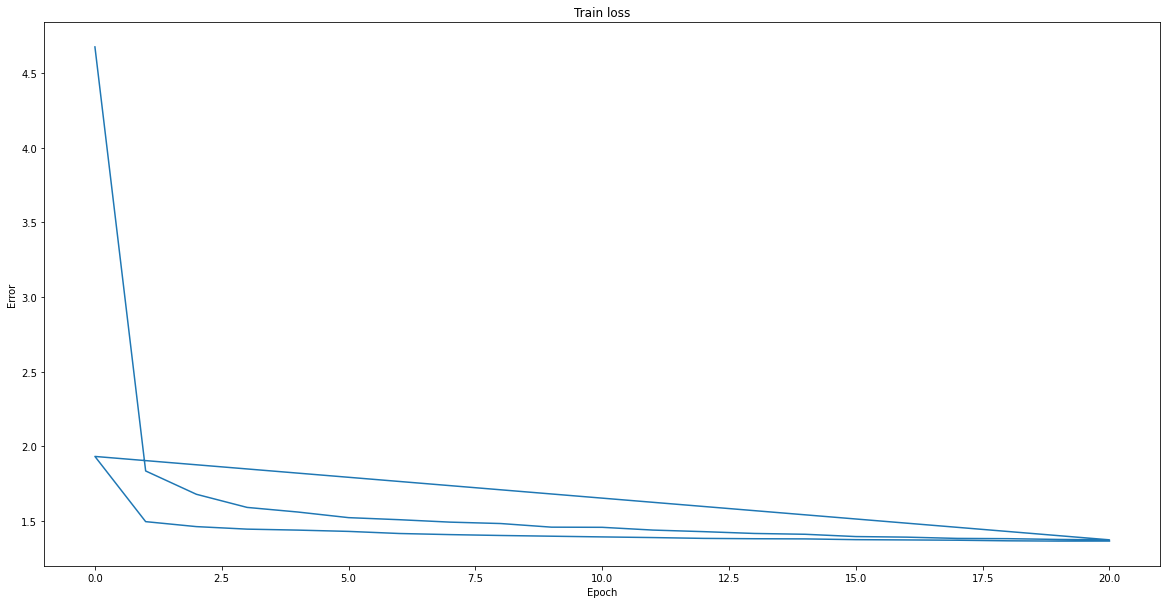

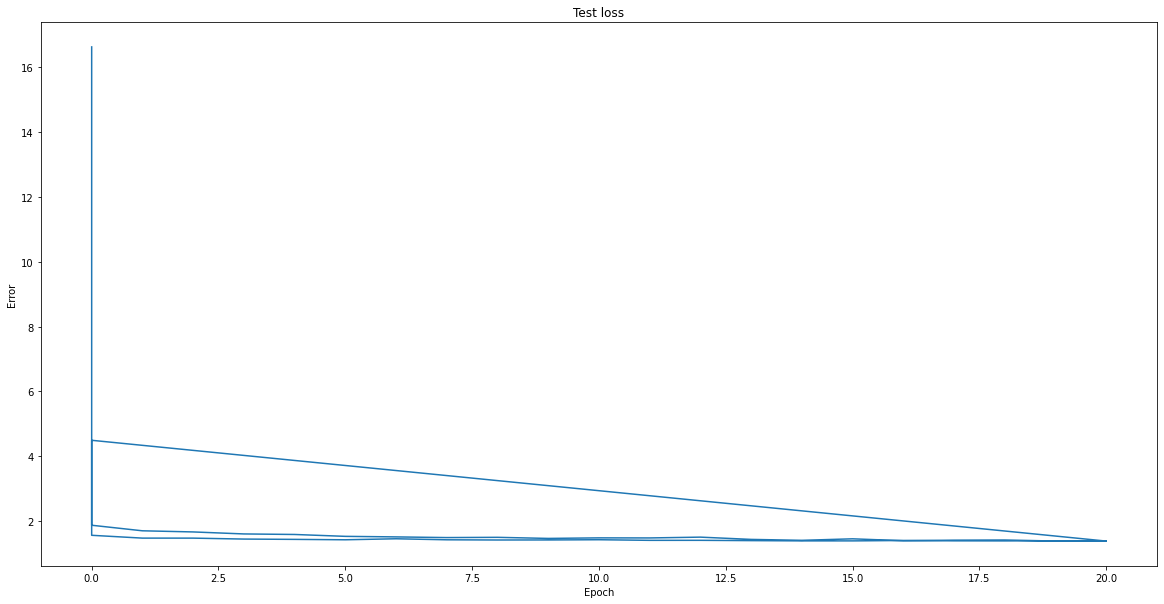

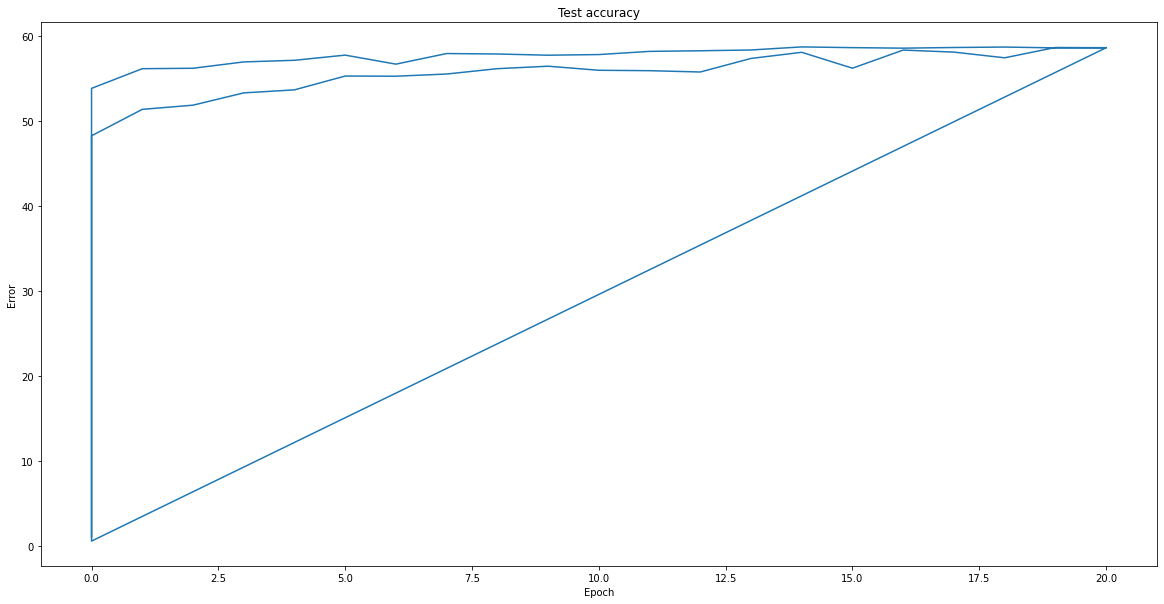

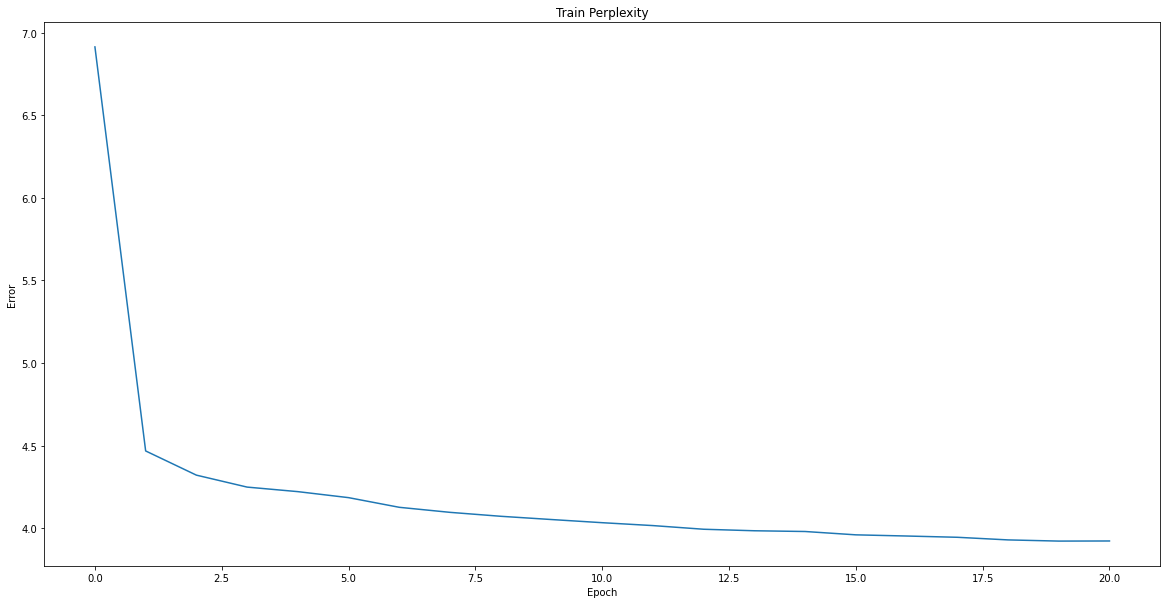

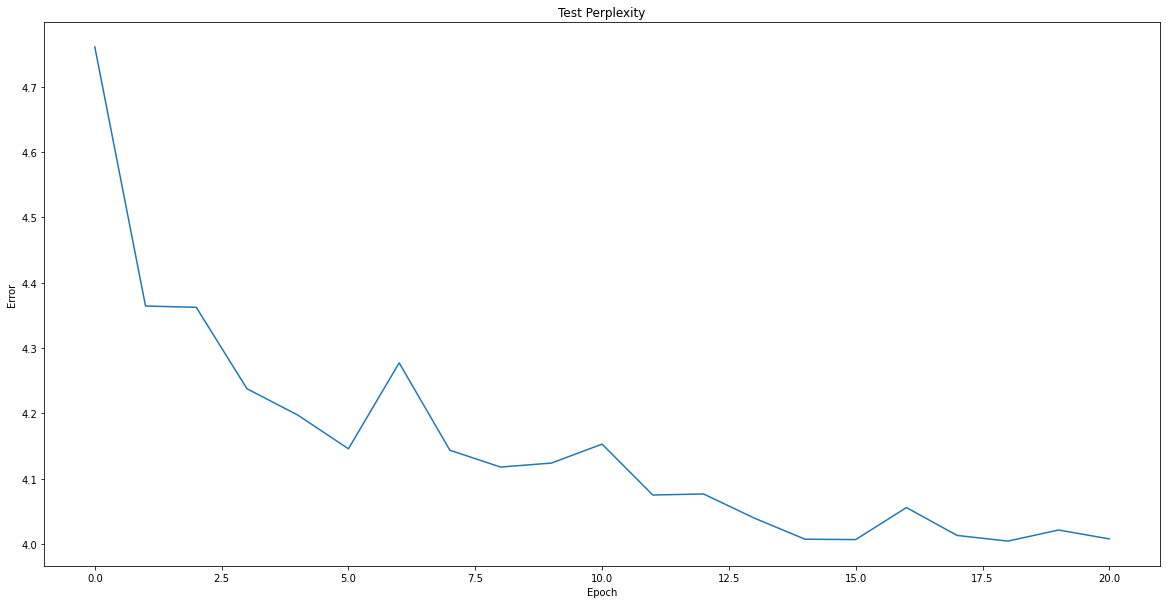

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + '/logs/log41.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)

    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    print("checking data_train:", len(data_train))
    print("checking data_test:", len(data_test))

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    
    print("checking train_loader:", len(train_loader))
    print("checking test_loader:", len(test_loader))

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    print("after model")

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    start_epoch = 0

    print("before train")

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    train_perplexities = []
    test_perplexities = []

    print("before test")
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the door was standing at the stairs and stared at the stairs and stared at the stairs and stared at the stairs and stared at the stairs and stared at the stairs and stared at the stairs and stared at the
generated with sample	 Harry Potter and the blass found shooted at that, It's unteld stood the Nure Hermione wore. Ya's exbectected?" said Ron coban at the impressire.  I was very glool. Hermione gave Hunar ron to his devers in her cold man th
generated with sample	 Harry Potter and then quick lumb and intrudening trontbled endigelently as Rust the glasse line Murdle and Voines ffoot fouder and screaking over and the shirm in dres, but looking overs he spoke out of swrees and snowd 
generated with sample	 Harry Potter and the feast old wand finesh great one) the other back slipping at Harry?" "No," said Harry. "I a voice of 'ighing Ministry Would short wark to met our staff of school. That let out his head in a rink sudde
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



In [ ]:
# 1. new corpus
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub(r"[\n\t\s]", " ", data)
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    index = 0
    for char in data:
      if char not in voc2ind:
        voc2ind[char] = index
        index += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    data_text = []
    for char in data:
      data_text.append(voc2ind[char])

    length = (int) (len(data_text) * 0.8)
    train_text = data_text[0:length]
    test_text = data_text[length:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))

prepare_data(DATA_PATH + 'lesmis.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [ ]:
# 2. new architecture
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)

        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, 300)
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150, self.vocab_size)
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [ ]:
# 2. lstm
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)

        self.lstm = nn.LSTM(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]

        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.

- We tried a number of modifications but found that the original worked best with a temperature of 0.1. We tried adding extra layers, changing batch size, changing learning rate, and changing sequence length, but none of those options worked well. Otherwise, no changes to the list of hyperparameters or other modifications.

![image.png](https://drive.google.com/uc?export=view&id=15S927zO-yIMWOngklUnX2mTvmcCln1Y4)

![image.png](https://drive.google.com/uc?export=view&id=1wT51pw_hQrnUKxCc_Fx6KlmVZvtAezhf)

![image.png](https://drive.google.com/uc?export=view&id=1UsVpcGfuqLv1G5ogoUeQ3VyQcw1Mra-0)

![image.png](https://drive.google.com/uc?export=view&id=1OX3DzuV8zmR1LGFgjMqih4DHbksBLuVr)

![image.png](https://drive.google.com/uc?export=view&id=1LLTA4cdViDGFDS8b2mkjHtYWcgBvL2ds)
    
2. What was your final test accuracy? What was your final test perplexity?
- The final test accuracy was about 60%. The final test perplexity was about 4.
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
- Sentence: What does a boundless UW student say?
- max: What does a boundless UW student say? I don't think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you th
- sample: Harry jut do it, there?"  "So who's he wanted a point of ruse insweithe."  It was detention for a dright snoce of fiftaden what onto fi7e move than he really gonble to Kryffind and Auddy Wlug still ho
- beam: omething, Harry could a got of teath fine presenven door connecting a hungues and blay new to Sopin point, and Harry widen't thin about it," said Hagrid stroke around.   The you for the smile nor blue
4. Which sampling method seemed to generate the best results? Why do you think that is?
- On average beam search seemed to generate the best results, since it provided the most varied results and expanded the possiblities to find reasonable combinations. Sampling search also generated pretty comparable results, but didn't seem to be as coherent in terms of sentence completion.
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
- Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
  - sample method produced the best output (funniest) with a temperature of 0.5: "You think you."  "Alike "Dudge duanstanted that my friel you think I''l have to your, fawing, Ron Encle he was looking ot that Lun would spear Flitwin   the twit, for they locked as Ion waped salize 
- What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
  - A temperature of 0 picks the character with the most probability (basically a max) which can lead to looping - eliminates randomness in sampling
  - A temperature of 0<temp<1 will add some randomness but still favor the original distribution
  - A temperature of 1 will not have an effect on the distribution
  - A temperature greater than 1 will create more uniformity when picking values
  - A negative temperature would give us values that are greater than 1 which would cause issues for our model
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    - We chose the complete text of the book Les Miserables, which contains 3,251,298 characters.
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    - We noticed that there was different vocabulary associated with the new corpus, likely meaning that the old and new corpora were written in different time periods. We also noticed a few character errors due to parsing on the new dataset (like unicode characters and things like that). There are more semicolons and longer sentences, meaning that the newer corpus seemed to have a far more sophisticated structure.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    - The temperature used was 0.5. Here are some outputs for the new corpus: 
    - max: The same time to the single with the same time to the single with the significant of the streets, and the same time to the single with the significant of the streets, and the same time to the single w
    - sample: Fome! In the opper of Cosette, from this walking seems. An old MaternoïK PRor I caugh to mean Vosette?”   “æobous extre, which had been which was the side. They meaulted consplains who were all to tha
    - beam: make, this pomice. A love with ephanswity, a wooden in that them ang of the poince? Th! Cosette time, in spectation when the antive movemed no resembled towy himself in the little Fait face might mom

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    - Our design was adding more layers (making the network deeper). We thought that adding more layers would create more connections in our network but it ended up giving identical accuracies in the end. We also tried changing several hyperparameters including batch size, learning rate, and also things like temperature. None of the changes gave significant boosts in the accuracies.
    2. What was your lowest test perplexity? Provide training and testing plots.
  - The lowest test perplexity was about 4.

![image.png](https://drive.google.com/uc?export=view&id=1OX3DzuV8zmR1LGFgjMqih4DHbksBLuVr)

![image.png](https://drive.google.com/uc?export=view&id=1LLTA4cdViDGFDS8b2mkjHtYWcgBvL2ds)
    
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

    - We used a temperature of 0.5
    - max: “The man was not the convent of the convent of the same to the police of the street of the street of the street of the street of the street of the street of the street of the street of the street of
    - sample: By night chyed wolld receive allube in the othericif ment on the Pholeer Collaire man. The to’R would mean uspects opsnalon, but You am lofty deas’ not lift gun leasing I am fabking, which bulkly on t
    - beam: The Montpertrict to him in himself wall skrug, and Carling directed of all adoracion-do﻿s of the does of wat contablect to him, leaver an indolshap restains, and dame duclor? Joabju no lover. Thatali

1. LSTM
    1. What new difficulties did you run into while training?
    - We had difficulty fitting the dimensions correctly but other than that nothing too much
    2. Were results better than the GRU? Provide training and testing plots.
    - The results were about the same as the GRU

![image.png](https://drive.google.com/uc?export=view&id=1N_jJHzDwiHTTPLCz5C_IzkYcIlrariv1)

![image.png](https://drive.google.com/uc?export=view&id=1EddbUXzU7qDKgwjiH_Rw_MSiyLmu9jFe)

![image.png](https://drive.google.com/uc?export=view&id=1RE_vmuob8qPVUm4k33-3vqDWps2q4rFz)


    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    - We used a temperature of 0.5
    - max: They said to the porter of the street of the street of the street of the street of the street of the street of the street of the street of the street of the street of the street of the street of the
    - sample: France of aughteous, come yorseably loying; alquying the town; that come tilent to late.  Wess, top understood. And thrust it this whot like to bare the barriers of liftentous shoulders, there was suc
    - beam: Mother Helps. God at Jag…:—  “Sest against he collent the priest, thruths:— This schile each opening in the pirtor, on therein anything; there felt it donesses it to then. This arrivides tigety usy po

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    